Dev notebook, getting training working with real data

In [1]:
import json
import pescador
import glob
import os
import numpy as np
import medleydb as mdb
import pandas as pd
import scipy

In [2]:
cd ../deepsalience/

/scratch/rmb456/multif0/deepsalience


In [3]:
from __future__ import print_function

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import glob
import librosa
import mir_eval
import numpy as np

import keras
from keras.models import Model
from keras.layers import Dense, Input, Reshape, Lambda, Permute
from keras.layers.merge import Concatenate, Multiply
from keras.layers.convolutional import Conv2D
from keras.layers.wrappers import TimeDistributed
from keras.layers.normalization import BatchNormalization
from keras import backend as K
import os

import compute_training_data as C
import experiment_datasets
import evaluate
import core

Using TensorFlow backend.


[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9899902529384173510
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11332668621
locality {
  bus_id: 1
}
incarnation: 11523425525099084100
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:05:00.0"
]


/home/rmb456/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [23]:
def get_grouped_data(json_path, mtrack_list):

    json_fpaths = glob.glob(os.path.join(json_path, '*.json'))

    XA_dat = []
    XB_dat = []
    XC_dat = []
    XD_dat = []

    for fpath in json_fpaths:

        track_id = '_'.join(os.path.basename(fpath).split('.')[0].split('_')[:2])
        if track_id not in mtrack_list:
            continue

        with open(fpath, 'r') as fhandle:
            dat = json.load(fhandle)

            for key in dat.keys():
                bname = os.path.basename(key).split('.')[0].split('_')
                if len(bname) == 4:
                    XA_dat.append([key, dat[key]])
                elif len(bname) == 6:
                    if bname[4] == 'resynth':
                        XB_dat.append([key, dat[key]])
                    elif bname[4] == 'noguitar':
                        XC_dat.append([key, dat[key]])
                    elif bname[4] == 'nosynth':
                        XD_dat.append([key, dat[key]])
                    else:
                        raise ValueError("bname[4] = {} not recognized".format(bname[4]))
                else:
                    raise ValueError("len(bname) = {} not recognized".format(len(bname)))

    return XA_dat, XB_dat, XC_dat, XD_dat


def grab_patch_output(f, t, n_f, n_t, y_data):
    """Get a time-frequency patch from an output file
    """
    return y_data[f: f + n_f, t: t + n_t][np.newaxis, :, :]


def grab_patch_input(f, t, n_f, n_t, x_data):
    """Get a time-frequency patch from an input file
    """
    return np.transpose(
        x_data[:, f: f + n_f, t: t + n_t], (1, 2, 0)
    )[np.newaxis, :, :, :]


def grab_empty_output(n_f, n_t):
    return np.zeros((1, n_f, n_t))


def multitask_patch_generator(fpath_in, dict_out, n_samples=20, input_patch_size=(360, 50)):
    """Generator that yields an infinite number of patches
       for a single input, output pair
    """
    data_in = np.load(fpath_in)
    data_out = {}
    for task in dict_out.keys():
        data_out[task] = np.load(dict_out[task])

    _, _, n_times = data_in.shape
    n_f, n_t = input_patch_size

    t_vals = np.arange(0, n_times - n_t)
    np.random.shuffle(t_vals)

    for t in t_vals[:n_samples]:
        f = 0
        t = np.random.randint(0, n_times - n_t)

        x_patch = grab_patch_input(
            f, t, n_f, n_t, data_in
        )
        # add frequency info to patch
        x_freqs = np.repeat(
            (1./n_f)*np.arange(n_f)[np.newaxis, :], n_t, axis=0
        ).T[np.newaxis, :, :, np.newaxis]
        x = np.concatenate([x_freqs, x_patch], axis=3)
        
        y = {}
        w = {}
        for task in ['multif0', 'melody', 'bass', 'vocal']:
            if task in data_out.keys():
                y_task = grab_patch_output(
                    f, t, n_f, n_t, data_out[task]
                )
                w[task] = 1.0
            else:
                y_task = grab_empty_output(n_f, n_t)
                w[task] = 0.0

            y[task] = y_task
            
        yield dict(X=x, Y=y, W=w)

        
def get_task_pairs(data_list, task):
    """Get a list of [input path, output dictionary] pairs where each
    element of the list has at least `task` as a key in the output dictionary.
    """
    task_pairs = []
    for input_file, task_dict in data_list:
        if task in task_dict.keys():
            task_pairs.append([input_file, task_dict])
    return task_pairs

def get_all_task_pairs(data_list):
    multif0_pairs = get_task_pairs(data_list, 'multif0')
    melody_pairs = get_task_pairs(data_list, 'melody')
    bass_pairs = get_task_pairs(data_list, 'bass')
    vocal_pairs = get_task_pairs(data_list, 'vocal')
    task_pairs = {
        'multif0': multif0_pairs,
        'melody': melody_pairs,
        'bass': bass_pairs,
        'vocal': vocal_pairs
    }
    return task_pairs


def multitask_batch_generator(multif0_generator, melody_generator,
                              bass_generator, vocal_generator):

    multif0_iter = multif0_generator.tuples('X', 'Y', 'W')
    melody_iter = melody_generator.tuples('X', 'Y', 'W')
    bass_iter = bass_generator.tuples('X', 'Y', 'W')
    vocal_iter = vocal_generator.tuples('X', 'Y', 'W')
    while True:
        mu = next(multif0_iter)
        me = next(melody_iter)
        ba = next(bass_iter)
        vo = next(vocal_iter)
        X = np.concatenate([mu[0], me[0], ba[0], vo[0]])
        Y = {}
        W = {}
        for task in ['multif0', 'melody', 'bass', 'vocal']:
            Y[task] = np.concatenate([mu[1][task], me[1][task], ba[1][task], vo[1][task]])
            W[task] = np.array([mu[2][task], me[2][task], ba[2][task], vo[2][task]])
        yield (X, Y, W)


def multitask_generator(mtrack_list):
    json_path = "/scratch/rmb456/multif0_ismir2017/multitask_data/XY_pairs"
    XA_dat, XB_dat, XC_dat, XD_dat = get_grouped_data(json_path, mtrack_list)
    
    XA_pairs = get_all_task_pairs(XA_dat)
    XB_pairs = get_all_task_pairs(XB_dat)
    XC_pairs = get_all_task_pairs(XC_dat)
    XD_pairs = get_all_task_pairs(XD_dat)
    
    # for each data type make a streamer for each file pair
    XA_streams = {'melody': [], 'bass': [], 'vocal': []}
    for task in XA_pairs.keys():
        if task == 'multif0':
            continue
        for pair in XA_pairs[task]:
            XA_streams[task].append(
                pescador.Streamer(multitask_patch_generator, pair[0], pair[1]))

    XB_streams = {'multif0': [], 'melody': [], 'bass': [], 'vocal': []}
    for task in XB_pairs.keys():
        for pair in XB_pairs[task]:
            XB_streams[task].append(
                pescador.Streamer(multitask_patch_generator, pair[0], pair[1]))

    XC_streams = {'multif0': [], 'melody': [], 'bass': [], 'vocal': []}
    for task in XC_pairs.keys():
        for pair in XC_pairs[task]:
            XC_streams[task].append(
                pescador.Streamer(multitask_patch_generator, pair[0], pair[1]))

    XD_streams = {'multif0': [], 'melody': [], 'bass': [], 'vocal': []}
    for task in XD_pairs.keys():
        for pair in XD_pairs[task]:
            XD_streams[task].append(
                pescador.Streamer(multitask_patch_generator, pair[0], pair[1]))

    # for each data type make a mux
    n_active = 10
    
    XA_mux = {}
    for task in XA_streams.keys():
        XA_mux[task] = pescador.Mux(
            XA_streams[task], n_active, with_replacement=True,
            lam=250, random_state=42
        )
    XB_mux = {}
    for task in XB_streams.keys():
        XB_mux[task] = pescador.Mux(
            XB_streams[task], n_active, with_replacement=True,
            lam=250, random_state=42
        )
    XC_mux = {}
    for task in XC_streams.keys():
        XC_mux[task] = pescador.Mux(
            XC_streams[task], n_active, with_replacement=True,
            lam=250, random_state=42
        )
    XD_mux = {}
    for task in XD_streams.keys():
        XD_mux[task] = pescador.Mux(
            XD_streams[task], n_active, with_replacement=True,
            lam=250, random_state=42
        )
        
    # for each task make a mux that samples from the data muxes
    multif0_streams = [
        XB_mux['multif0'],
        XC_mux['multif0'], XD_mux['multif0']]
    melody_streams = [
        XA_mux['melody'], XB_mux['melody'],
        XC_mux['melody'], XD_mux['melody']]    
    bass_streams = [
        XA_mux['bass'], XB_mux['bass'],
        XC_mux['bass'], XD_mux['bass']]
    vocal_streams = [
        XA_mux['vocal'], XB_mux['vocal'],
        XC_mux['vocal'], XD_mux['vocal']]    

#     multif0_mux = pescador.Mux(multif0_streams, 1, pool_weights=[0.2, 0.3, 0.5])
#     melody_mux = pescador.Mux(melody_streams, 1, pool_weights=[0.5, 0.1, 0.1, 0.3])
#     bass_mux = pescador.Mux(bass_streams, 1, pool_weights=[0.5, 0.1, 0.1, 0.3])
#     vocal_mux = pescador.Mux(vocal_streams, 1, pool_weights=[0.5, 0.1, 0.1, 0.3])
    
    multif0_mux = pescador.Mux(multif0_streams, 1, pool_weights=[0.1, 0.4, 0.5])
    melody_mux = pescador.Mux(melody_streams, 1, pool_weights=[0.3, 0.3, 0.1, 0.3])
    bass_mux = pescador.Mux(bass_streams, 1, pool_weights=[0.3, 0.3, 0.1, 0.3])
    vocal_mux = pescador.Mux(vocal_streams, 1, pool_weights=[0.3, 0.3, 0.1, 0.3])

    batch_gen = multitask_batch_generator(
        multif0_mux, melody_mux,
        bass_mux, vocal_mux
    )

    for batch in batch_gen:
        yield batch

In [24]:
with open(core.data_splits_path(), 'r') as fhandle:
    data_splits = json.load(fhandle)
print(data_splits.keys())

[u'test', u'validate', u'train']


In [25]:
train_generator = multitask_generator(data_splits['train'])
validate_generator = multitask_generator(data_splits['validate'])
test_generator = multitask_generator(data_splits['test'])

In [26]:
input_shape = (None, None, 6)
y0 = Input(shape=input_shape)

# y0 = BatchNormalization()(inputs)

y1_pitch = Conv2D(
    32, (5, 5), padding='same', activation='relu', name='pitch_layer1')(y0)
y1a_pitch = BatchNormalization()(y1_pitch)
y2_pitch = Conv2D(
    32, (5, 5), padding='same', activation='relu', name='pitch_layer2')(y1a_pitch)
y2a_pitch = BatchNormalization()(y2_pitch)
y3_pitch = Conv2D(32, (3, 3), padding='same', activation='relu', name='smoothy2')(y2a_pitch)
y3a_pitch = BatchNormalization()(y3_pitch)
y4_pitch = Conv2D(8, (70, 3), padding='same', activation='relu', name='distribute')(y3a_pitch)
y4a_pitch = BatchNormalization()(y4_pitch)

y_multif0 = Conv2D(
    1, (1, 1), padding='same', activation='sigmoid', name='multif0_presqueeze')(y4a_pitch)
multif0 = Lambda(lambda x: K.squeeze(x, axis=3), name='multif0')(y_multif0)

y_mask = Multiply(name='mask')([y_multif0, y0])
y1_timbre = Conv2D(
    512, (2, 3), padding='same', activation='relu', name='timbre_layer1')(y_mask)
y1a_timbre = BatchNormalization()(y1_timbre)

y_concat = Concatenate(name='timbre_and_pitch')([y_multif0, y1a_timbre])
ya_concat = BatchNormalization()(y_concat)

y_mel_feat = Conv2D(
    32, (3, 3), padding='same', activation='relu', name='melody_filters')(ya_concat)
ya_mel_feat = BatchNormalization()(y_mel_feat)
y_mel_feat2 = Conv2D(
    32, (3, 3), padding='same', activation='relu', name='melody_filters2')(ya_mel_feat)
ya_mel_feat2 = BatchNormalization()(y_mel_feat2)
y_mel_feat3 = Conv2D(
    8, (240, 1), padding='same', activation='relu', name='melody_filters3')(ya_mel_feat2)
ya_mel_feat3 = BatchNormalization()(y_mel_feat3)
y_mel_feat4 = Conv2D(
    16, (7, 7), padding='same', activation='relu', name='melody_filters4')(ya_mel_feat3)
ya_mel_feat4 = BatchNormalization()(y_mel_feat4)
y_mel_feat5 = Conv2D(
    16, (7, 7), padding='same', activation='relu', name='melody_filters5')(ya_mel_feat4)
ya_mel_feat5 = BatchNormalization()(y_mel_feat5)

y_bass_feat = Conv2D(
    32, (3, 3), padding='same', activation='relu', name='bass_filters')(ya_concat)
ya_bass_feat = BatchNormalization()(y_bass_feat)
y_bass_feat2 = Conv2D(
    32, (3, 3), padding='same', activation='relu', name='bass_filters2')(ya_bass_feat)
ya_bass_feat2 = BatchNormalization()(y_bass_feat2)
y_bass_feat3 = Conv2D(
    8, (240, 1), padding='same', activation='relu', name='bass_filters3')(ya_bass_feat2)
ya_bass_feat3 = BatchNormalization()(y_bass_feat3)
y_bass_feat4 = Conv2D(
    16, (7, 7), padding='same', activation='relu', name='bass_filters4')(ya_bass_feat3)
ya_bass_feat4 = BatchNormalization()(y_bass_feat4)
y_bass_feat5 = Conv2D(
    16, (7, 7), padding='same', activation='relu', name='bass_filters5')(ya_bass_feat4)
ya_bass_feat5 = BatchNormalization()(y_bass_feat5)

y_vocal_feat = Conv2D(
    32, (3, 3), padding='same', activation='relu', name='vocal_filters')(ya_concat)
ya_vocal_feat = BatchNormalization()(y_vocal_feat)
y_vocal_feat2 = Conv2D(
    32, (3, 3), padding='same', activation='relu', name='vocal_filters2')(ya_vocal_feat)
ya_vocal_feat2 = BatchNormalization()(y_vocal_feat2)
y_vocal_feat3 = Conv2D(
    8, (240, 1), padding='same', activation='relu', name='vocal_filters3')(ya_vocal_feat2)
ya_vocal_feat3 = BatchNormalization()(y_vocal_feat3)
y_vocal_feat4 = Conv2D(
    16, (7, 7), padding='same', activation='relu', name='vocal_filters4')(ya_vocal_feat3)
ya_vocal_feat4 = BatchNormalization()(y_vocal_feat4)
y_vocal_feat5 = Conv2D(
    16, (7, 7), padding='same', activation='relu', name='vocal_filters5')(ya_vocal_feat4)
ya_vocal_feat5 = BatchNormalization()(y_vocal_feat5)

y_melody = Conv2D(
    1, (1, 1), padding='same', activation='sigmoid', name='melody_presqueeze')(ya_mel_feat5)
melody = Lambda(lambda x: K.squeeze(x, axis=3), name='melody')(y_melody)

y_bass = Conv2D(
    1, (1, 1), padding='same', activation='sigmoid', name='bass_presqueeze')(ya_bass_feat5)
bass = Lambda(lambda x: K.squeeze(x, axis=3), name='bass')(y_bass)

y_vocal = Conv2D(
    1, (1, 1), padding='same', activation='sigmoid', name='vocal_presqueeze')(ya_vocal_feat5)
vocal = Lambda(lambda x: K.squeeze(x, axis=3), name='vocal')(y_vocal)

model = Model(inputs=y0, outputs=[multif0, melody, bass, vocal])

In [27]:
model.summary(line_length=120)

________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_1 (InputLayer)                   (None, None, None, 6)      0                                                     
________________________________________________________________________________________________________________________
pitch_layer1 (Conv2D)                  (None, None, None, 32)     4832                                                  
________________________________________________________________________________________________________________________
batch_normalization_1 (BatchNormalizat (None, None, None, 32)     128                                                   
________________________________________________________________________________________________________________________
pitch_layer2 (Conv2D)           

In [28]:
def bkld(y_true, y_pred):
    """Brian's KL Divergence implementation
    """
    y_true = K.clip(y_true, K.epsilon(), 1.0 - K.epsilon())
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    return K.mean(K.mean(
        -1.0*y_true* K.log(y_pred) - (1.0 - y_true) * K.log(1.0 - y_pred),
        axis=-1), axis=-1)

In [29]:
model.compile(
    loss=bkld, metrics=['mse', core.soft_binary_accuracy],
    loss_weights={'multif0': 2.0, 'melody': 1.0, 'bass': 1.0, 'vocal': 1.0},
    optimizer='adam', sample_weight_mode={'multif0': None, 'melody': None, 'bass': None, 'vocal': None}
)

In [30]:
SAMPLES_PER_EPOCH = 50
NB_EPOCHS = 200
NB_VAL_SAMPLES = 10

history = model.fit_generator(
    train_generator, SAMPLES_PER_EPOCH, epochs=NB_EPOCHS, verbose=1,
    validation_data=validate_generator, validation_steps=NB_VAL_SAMPLES,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            "../outputs/multitask_realdata_test_freqs.pkl", save_best_only=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1),
        keras.callbacks.EarlyStopping(patience=25, verbose=0)
    ]
)

Epoch 1/200
50/50 [==============================] - 399s - loss: 3.2202 - multif0_loss: 0.6481 - melody_loss: 0.6446 - bass_loss: 0.6408 - vocal_loss: 0.6386 - multif0_mean_squared_error: 0.2225 - multif0_soft_binary_accuracy: 0.7917 - melody_mean_squared_error: 0.2240 - melody_soft_binary_accuracy: 0.8007 - bass_mean_squared_error: 0.2219 - bass_soft_binary_accuracy: 0.8445 - vocal_mean_squared_error: 0.2212 - vocal_soft_binary_accuracy: 0.8322 - val_loss: 2.8912 - val_multif0_loss: 0.6178 - val_melody_loss: 0.5222 - val_bass_loss: 0.5681 - val_vocal_loss: 0.5652 - val_multif0_mean_squared_error: 0.2081 - val_multif0_soft_binary_accuracy: 0.9793 - val_melody_mean_squared_error: 0.1647 - val_melody_soft_binary_accuracy: 0.9964 - val_bass_mean_squared_error: 0.1864 - val_bass_soft_binary_accuracy: 0.9939 - val_vocal_mean_squared_error: 0.1857 - val_vocal_soft_binary_accuracy: 0.9965
Epoch 2/200
50/50 [==============================] - 66s - loss: 2.5414 - multif0_loss: 0.5295 - melody_

KeyboardInterrupt: 

In [31]:
model.load_weights("../outputs/multitask_realdata_test_freqs.pkl")

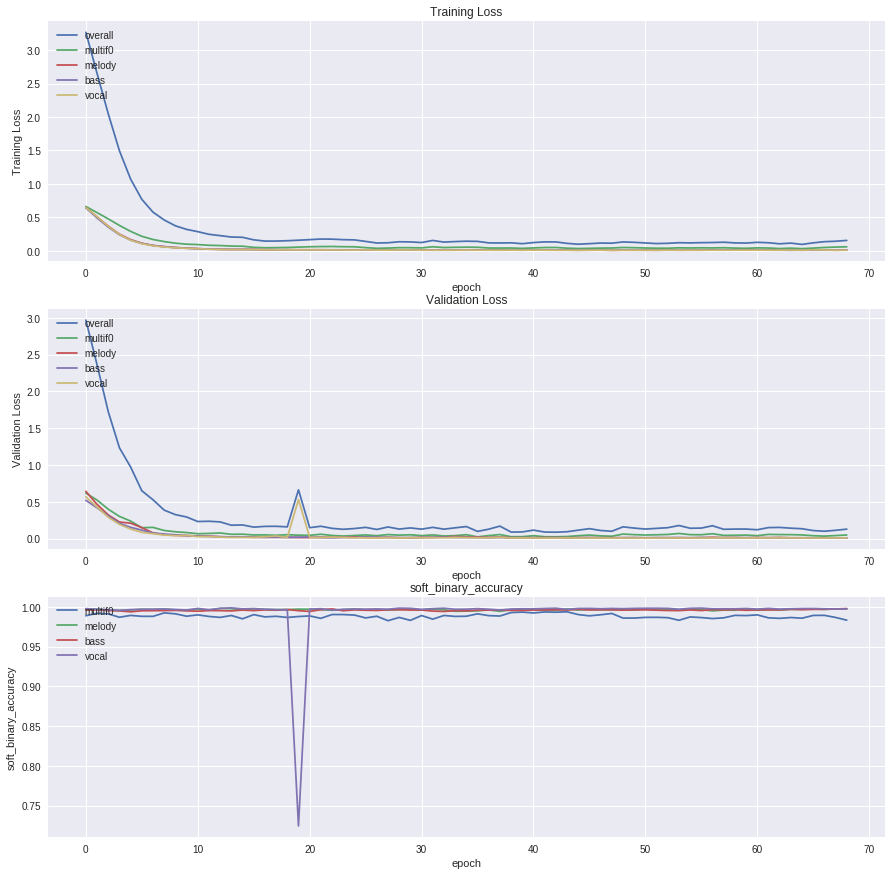

In [14]:
"""create and save plot of loss and metrics across epochs
"""
plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['multif0_loss'])
plt.plot(history.history['melody_loss'])
plt.plot(history.history['bass_loss'])
plt.plot(history.history['vocal_loss'])
plt.title('Training Loss')
plt.ylabel('Training Loss')
plt.xlabel('epoch')
plt.legend(['overall', 'multif0', 'melody', 'bass', 'vocal'], loc='upper left')

plt.subplot(3, 1, 2)
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_multif0_loss'])
plt.plot(history.history['val_melody_loss'])
plt.plot(history.history['val_bass_loss'])
plt.plot(history.history['val_vocal_loss'])
plt.title('Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('epoch')
plt.legend(['overall', 'multif0', 'melody', 'bass', 'vocal'], loc='upper left')

plt.subplot(3, 1, 3)
# plt.plot(history.history['val_soft_binary_accuracy'])
plt.plot(history.history['val_multif0_soft_binary_accuracy'])
plt.plot(history.history['val_melody_soft_binary_accuracy'])
plt.plot(history.history['val_bass_soft_binary_accuracy'])
plt.plot(history.history['val_vocal_soft_binary_accuracy'])
plt.title('soft_binary_accuracy')
plt.ylabel('soft_binary_accuracy')
plt.xlabel('epoch')
plt.legend(['multif0', 'melody', 'bass', 'vocal'], loc='upper left')


In [34]:
def get_single_test_prediction(model, npy_file=None, audio_file=None, max_frames=None):
    """Generate output from a model given an input numpy file
    """
    if npy_file is not None:
        input_hcqt = np.load(npy_file)
    elif audio_file is not None:
        input_hcqt = (C.compute_hcqt(audio_file)).astype(np.float32)
    else:
        raise ValueError("one of npy_file or audio_file must be specified")

    input_hcqt = input_hcqt.transpose(1, 2, 0)[np.newaxis, :, :, :]
    
    if max_frames is not None:
        input_hcqt = input_hcqt[:, :, :max_frames, :]

    n_t = input_hcqt.shape[2]
    n_f = input_hcqt.shape[1]
    x_freqs = np.repeat(
        (1./n_f)*np.arange(n_f)[np.newaxis, :], n_t, axis=0
    ).T[np.newaxis, :, :, np.newaxis]
    x = np.concatenate([x_freqs, input_hcqt], axis=3)
    n_slices = 1000
    t_slices = list(np.arange(0, n_t, n_slices))
    output_list = [[], [], [], []]
    for t in t_slices:
        prediction = model.predict(x[:, :, t:t+n_slices, :])
        for i, pred in enumerate(prediction):
            output_list[i].append(prediction[i][0, :, :])

    predicted_output = [[], [], [], []]
    for i in range(len(output_list)):
        predicted_output[i] = np.hstack(output_list[i])

    return predicted_output, input_hcqt

MusicDelta_Reggae_MIX_input.npy


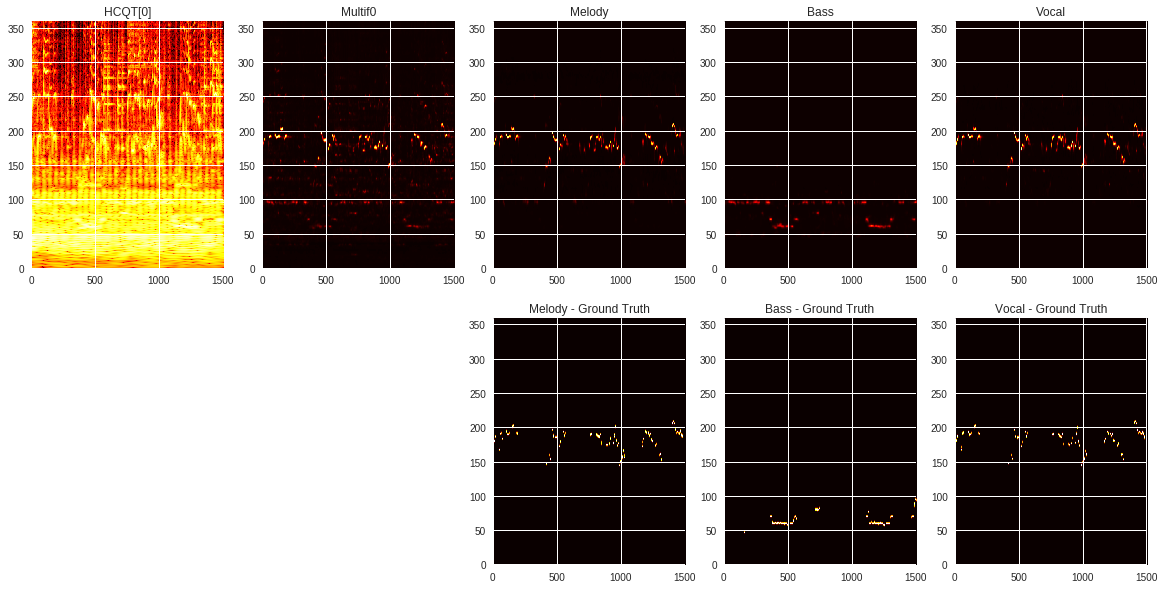

MusicDelta_SwingJazz_MIX_input.npy


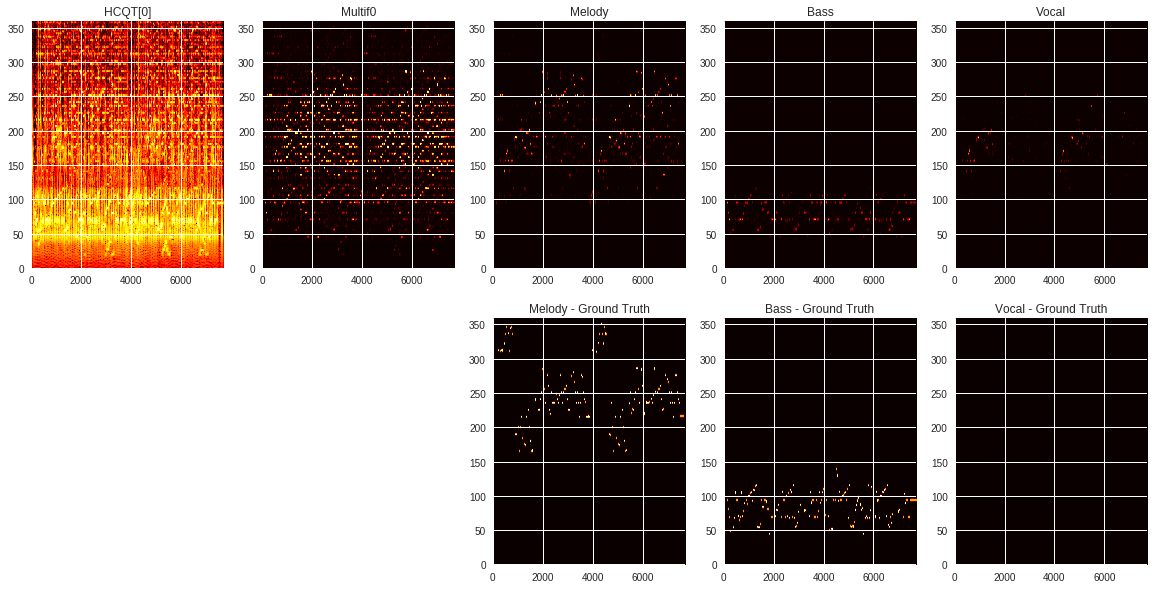

MatthewEntwistle_DontYouEver_MIX_input.npy


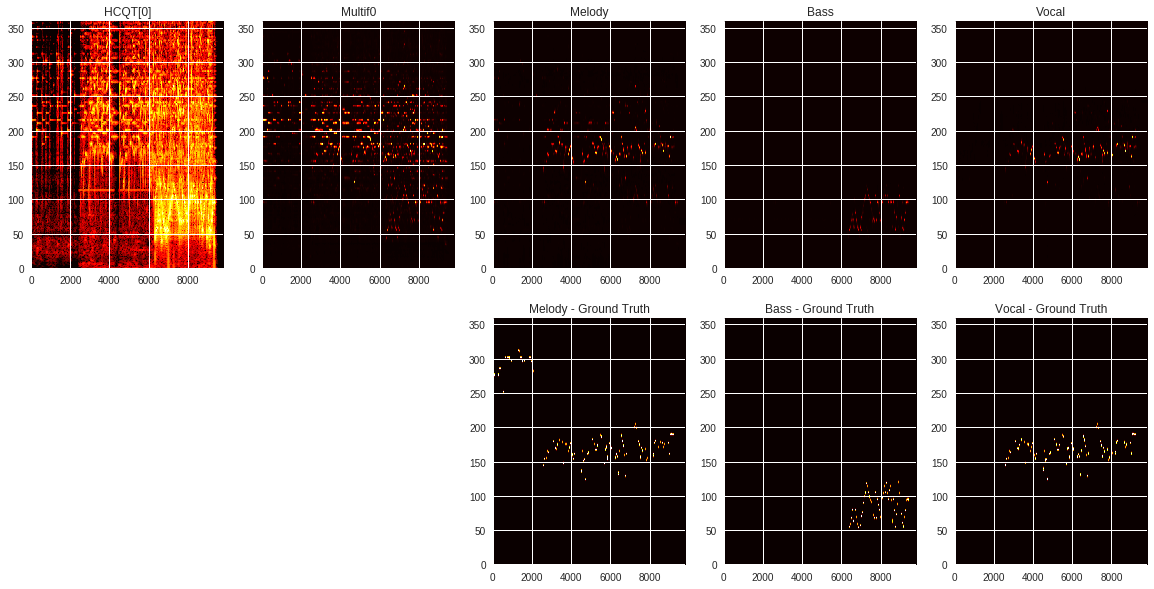

MusicDelta_LatinJazz_MIX_input.npy


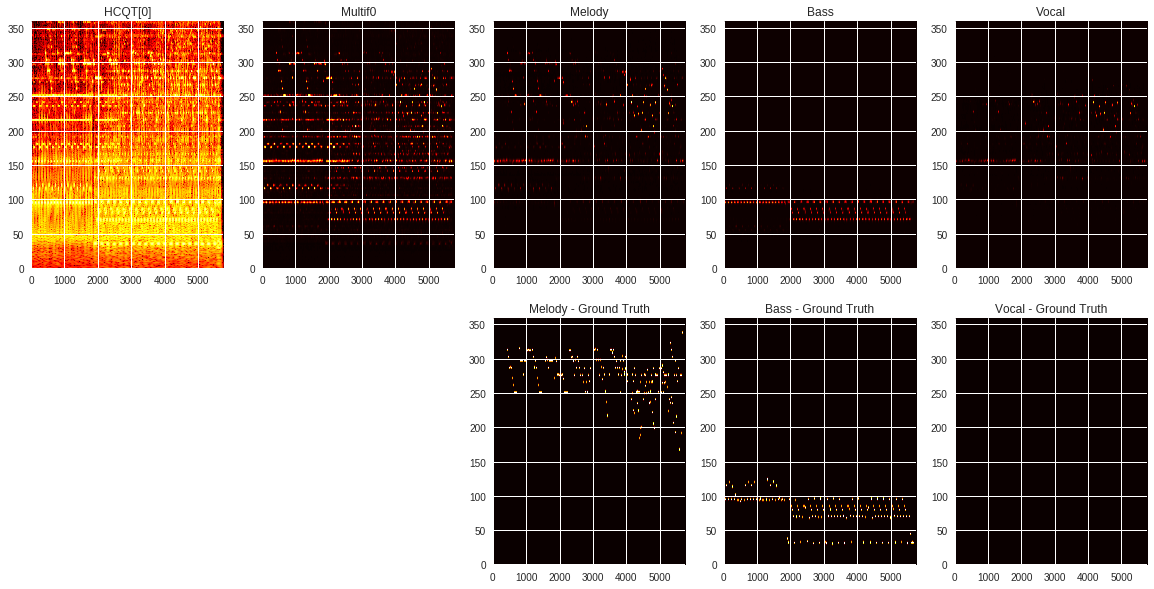

MusicDelta_GriegTrolltog_MIX_input.npy


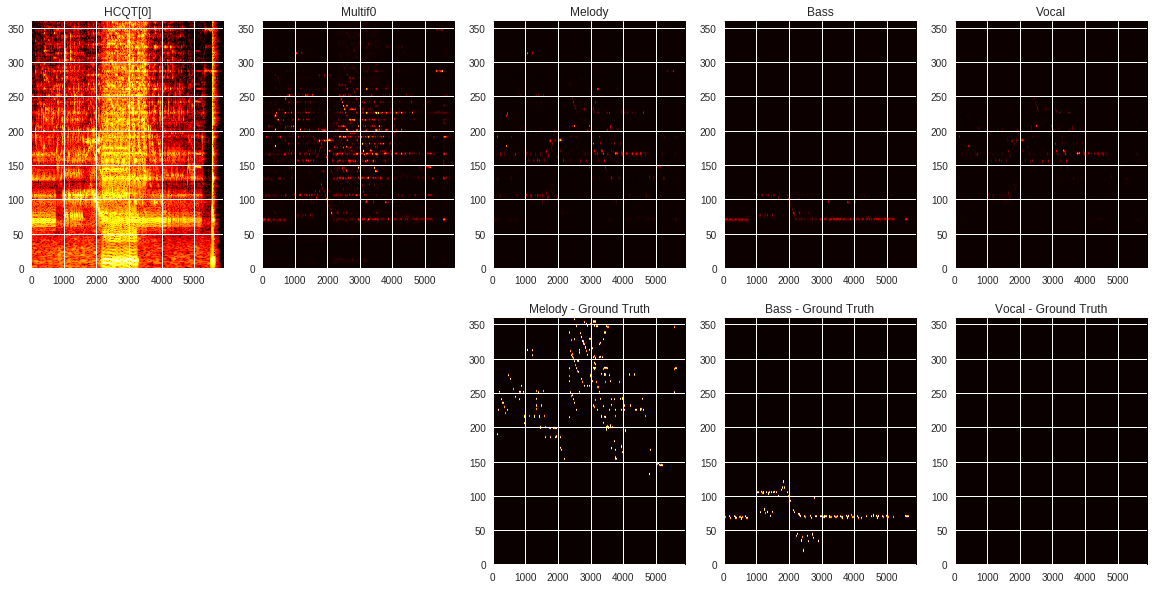

In [35]:
test_tracks = data_splits['test']
test_tracks = [
    'MusicDelta_Reggae', 'MusicDelta_SwingJazz',
    'MatthewEntwistle_DontYouEver', 'MusicDelta_LatinJazz',
    'MusicDelta_GriegTrolltog'
]
for track_id in test_tracks:
    
    json_fpath = "/scratch/rmb456/multif0_ismir2017/multitask_data/XY_pairs/{}_XY_pairs.json".format(track_id)
    with open(json_fpath, 'r') as fhandle:
        dat = json.load(fhandle)
        
    npy_input_file = os.path.join(
        '/scratch/rmb456/multif0_ismir2017/multitask_data/XY_pairs/{}_MIX_input.npy'.format(track_id))
    
    predicted_outputs, hcqt = get_single_test_prediction(model, npy_file=npy_input_file)
    
    dat_output = dat[npy_input_file]
    if 'multif0' in dat_output.keys():
        true_output_multif0 = np.load(dat_output['multif0'])
    else:
        true_output_multif0 = None
    if 'melody' in dat_output.keys():
        true_output_melody = np.load(dat_output['melody'])
    else:
        true_output_melody = None
    if 'bass' in dat_output.keys():
        true_output_bass = np.load(dat_output['bass'])
    else:
        true_output_bass = None
    if 'vocal' in dat_output.keys():
        true_output_vocal = np.load(dat_output['vocal'])
    else:
        true_output_vocal = None
    
    print(os.path.basename(npy_input_file))
    
    plt.figure(figsize=(20,10))

    plt.subplot(251)
    plt.title("HCQT[0]")
    plt.imshow(hcqt[0, :, :, 0], origin='lower', cmap='hot')
    plt.axis('tight')

    plt.subplot(252)
    plt.title("Multif0")
    plot_temp = predicted_outputs[0]
    plt.imshow(plot_temp, origin='lower', clim=[0, 1], cmap='hot')
    plt.axis('tight')
    
    if true_output_multif0 is not None:
        plt.subplot(257)
        plt.title("Multif0 - Ground Truth")
        plt.imshow(true_output_multif0, origin='lower', clim=[0, 1], cmap='hot')
        plt.axis('tight')

    plt.subplot(253)
    plt.title("Melody")
    plot_temp = predicted_outputs[1]
    plt.imshow(plot_temp, origin='lower', clim=[0, 1], cmap='hot')
    plt.axis('tight')

    if true_output_melody is not None:
        plt.subplot(258)
        plt.title("Melody - Ground Truth")
        plt.imshow(true_output_melody, origin='lower', clim=[0, 1], cmap='hot')
        plt.axis('tight')

    
    plt.subplot(254)
    plt.title("Bass")
    plot_temp = predicted_outputs[2]
    plt.imshow(plot_temp, origin='lower', clim=[0, 1], cmap='hot')
    plt.axis('tight')
    
    if true_output_bass is not None:
        plt.subplot(259)
        plt.title("Bass - Ground Truth")
        plt.imshow(true_output_bass, origin='lower', clim=[0, 1], cmap='hot')
        plt.axis('tight')
    
    plt.subplot(255)
    plt.title("Vocal")
    plot_temp = predicted_outputs[3]
    plt.imshow(plot_temp, origin='lower', clim=[0, 1], cmap='hot')
    plt.axis('tight')

    if true_output_vocal is not None:
        plt.subplot(2,5,10)
        plt.title("Vocal - Ground Truth")
        plt.imshow(true_output_vocal, origin='lower', clim=[0, 1], cmap='hot')
        plt.axis('tight')
    
    plt.show()

In [12]:
from mir_eval import sonify
import compute_training_data as C
import scipy
from scipy.interpolate import interp1d

In [17]:
def pitch_activations_to_mf0(pitch_activation_mat, thresh):
    """Convert a pitch activation map to multif0 by thresholding peak values
    at thresh
    """
    freqs = C.get_freq_grid()
    times = C.get_time_grid(pitch_activation_mat.shape[1])

    peak_thresh_mat = np.zeros(pitch_activation_mat.shape)
    peaks = scipy.signal.argrelmax(pitch_activation_mat, axis=0)
    peak_thresh_mat[peaks] = pitch_activation_mat[peaks]

    idx = np.where(peak_thresh_mat >= thresh)

    est_freqs = [[] for _ in range(len(times))]
    est_amps = [[] for _ in range(len(times))]
    for f, t in zip(idx[0], idx[1]):
        est_freqs[t].append(freqs[f])
        est_amps[t].append(pitch_activation_mat[f, t])

    est_freqs = [np.array(lst) for lst in est_freqs]
    return times, est_freqs, est_amps

def sonify_pitch_contour(times, frequencies, amplitudes, fs, length):
    fs = float(fs)

    if length is None:
        length = int(times.max() * fs)

    # Squash the negative frequencies.
    # wave(0) = 0, so clipping here will un-voice the corresponding instants
    frequencies = np.maximum(frequencies, 0.0)

    # Build a frequency interpolator
    f_interp = interp1d(times * fs, 2 * np.pi * frequencies / fs, kind='linear',
                        fill_value=0.0, bounds_error=False, copy=False)
    amp_interp = interp1d(times*fs, amplitudes, kind='linear', fill_value=0.0,
                          bounds_error=False, copy=False)
    
    # Estimate frequency at sample points
    f_est = f_interp(np.arange(length))
    a_est = amp_interp(np.arange(length))

    # Sonify the waveform
    return a_est * np.sin(np.cumsum(f_est))

In [ ]:
track_id = 'AClassicEducation_NightOwl'
npy_input_file = os.path.join(
        '/scratch/rmb456/multif0_ismir2017/multitask_data/XY_pairs/{}_MIX_input.npy'.format(track_id))
predicted_outputs, hcqt = get_single_test_prediction(
    model, npy_file=npy_input_file, max_frames=4000)

for tag, pred in zip(['multif0', 'melody', 'bass', 'vocal'], predicted_outputs):
    print(tag)
    est_times, est_freqs, est_amps = pitch_activations_to_mf0(
        pred, 0.3
    )
    
    max_n_freqs = np.max([len(f) for f in est_freqs])
    stream_times = [[] for i in range(max_n_freqs)]
    stream_freqs = [[] for i in range(max_n_freqs)]
    stream_amps = [[] for i in range(max_n_freqs)]

    for t, freqs, amps in zip(est_times, est_freqs, est_amps):
        for i, (f, a) in enumerate(zip(freqs, amps)):
            stream_times[i].append(t)
            stream_freqs[i].append(f)
            stream_amps[i].append(a)

    freq_grid = C.get_freq_grid()
    time_grid = C.get_time_grid(hcqt.shape[2])
    time_bins = C.grid_to_bins(time_grid, 0.0, time_grid[-1])
    freq_bins = C.grid_to_bins(freq_grid, 0.0, freq_grid[-1])
  
    fs = 44100
    n_freqs = len(freq_grid)
    n_times = len(time_grid)
    
    length = int(time_grid[-1] * fs)
    y_synth = np.zeros((length, ))
    for stream_t, stream_f, stream_a in zip(stream_times, stream_freqs, stream_amps):
        
        time_idx = np.digitize(np.array(stream_t), time_bins) - 1
        freq_idx = np.digitize(np.array(stream_f), freq_bins) - 1
        
        idx = time_idx < n_times
        time_idx = time_idx[idx]
        freq_idx = freq_idx[idx]

        idx2 = freq_idx < n_freqs
        time_idx = time_idx[idx2]
        freq_idx = freq_idx[idx2]

        freqs_contour = np.zeros((n_times, ))
        amps_contour = np.zeros((n_times, ))
        for t, f, a in zip(time_idx, freq_idx, stream_a):
            freqs_contour[t] = freq_grid[f]
            amps_contour[t] = a
    
        y_temp = sonify_pitch_contour(
            time_grid, freqs_contour, amps_contour, fs, length=length
        )
        y_synth = y_synth + y_temp

    librosa.output.write_wav(
        "../outputs/{}_{}_synth_out.wav".format(track_id, tag),
        y_synth, 44100, norm=True
    )
    
    

In [ ]:
import sox
tfm = sox.Transformer()
for fpath in glob.glob("../outputs/{}*_synth_out.wav".format(track_id)):
    bname = os.path.basename(fpath).split('.')[0]
    tfm.build(fpath, os.path.join('../outputs', "{}.aiff".format(bname)))

In [14]:
track_id = 'MusicDelta_LatinJazz'
npy_file = os.path.join(
        '/scratch/rmb456/multif0_ismir2017/multitask_data/XY_pairs/{}_MIX_input.npy'.format(track_id))
data = np.load(npy_file).transpose(1, 2, 0)[np.newaxis, :, :1500, :]

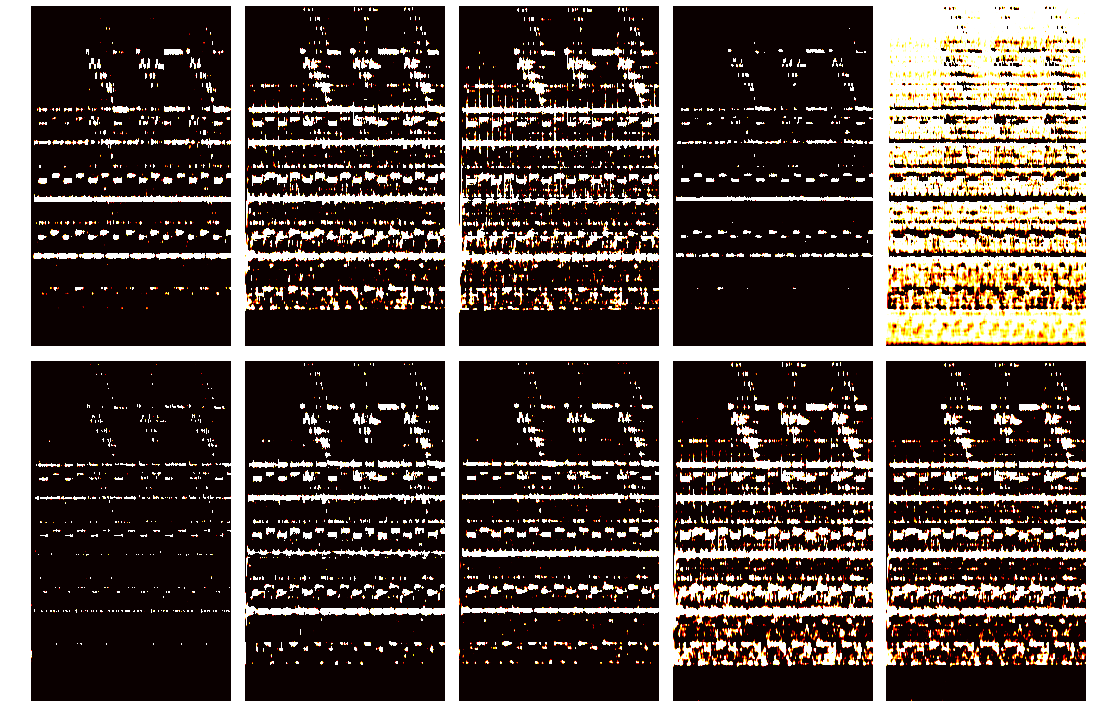

In [15]:
intermediate_layer = keras.models.Model(inputs=model.input,
                                 outputs=model.get_layer('bass_filters').output)
intermediate_output = intermediate_layer.predict(data)

plt.figure(figsize=(15, 10))
for i, layer in enumerate(range(10)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(intermediate_output[0, :, :, layer], origin='lower', cmap='hot', clim=[0, 1])
    plt.axis('tight')
    plt.axis('off')
plt.subplots_adjust(wspace=-8, hspace=-10)
plt.tight_layout()

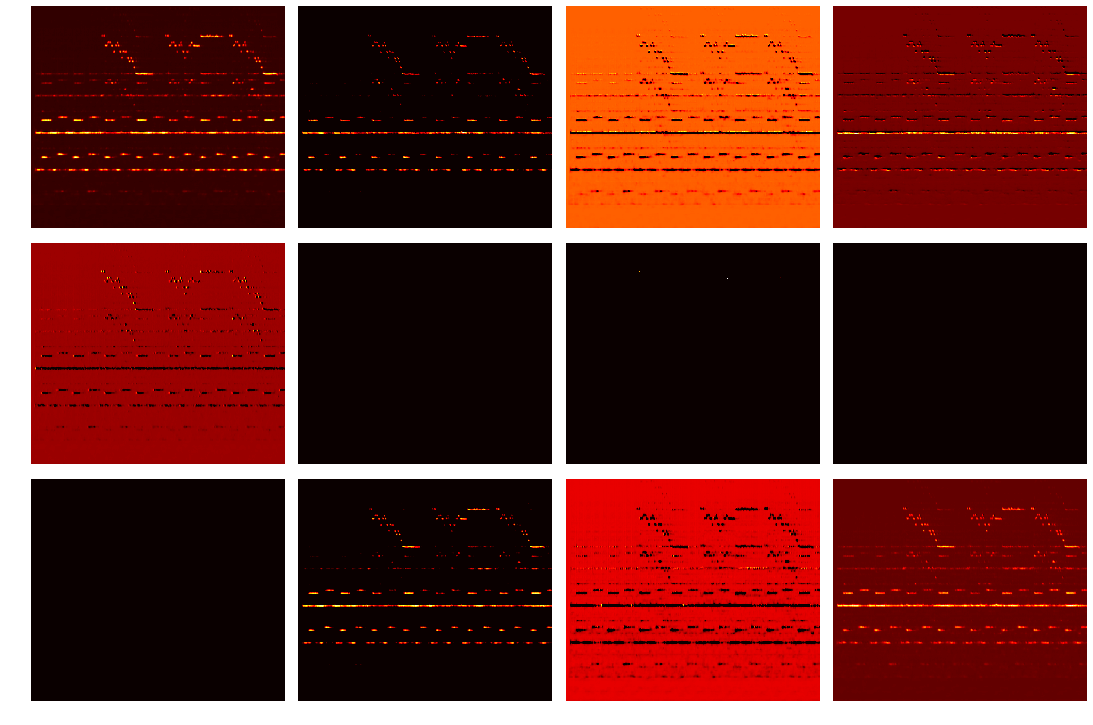

In [17]:
intermediate_layer = keras.models.Model(inputs=model.input,
                                 outputs=model.get_layer('timbre_layer1').output)
intermediate_output = intermediate_layer.predict(data)

plt.figure(figsize=(15, 10))
for i, layer in enumerate(range(0, 12)):
    plt.subplot(3, 4, i + 1)
    plt.imshow(intermediate_output[0, :, :, layer], origin='lower', cmap='hot')
    plt.axis('tight')
    plt.axis('off')
plt.subplots_adjust(wspace=-8, hspace=-10)
plt.tight_layout()

In [18]:
batch = train_generator.next()
hcqt = batch[0]
predicted_outputs = [batch[1]['multif0'], batch[1]['melody'], batch[1]['bass'], batch[1]['vocal']]
print(hcqt.shape)

plt.figure(figsize=(20,5))
idx = 0
plt.subplot(151)
plt.title("HCQT[0]")
plt.imshow(hcqt[idx, :, :, 0], origin='lower', cmap='hot')
plt.axis('tight')

plt.subplot(152)
plt.title("Multif0")
plt.imshow(predicted_outputs[0][idx], origin='lower', cmap='hot')
plt.axis('tight')

plt.subplot(153)
plt.title("Melody")
plt.imshow(predicted_outputs[1][idx], origin='lower', cmap='hot')
plt.axis('tight')

plt.subplot(154)
plt.title("Bass")
plt.imshow(predicted_outputs[2][idx], origin='lower', cmap='hot')
plt.axis('tight')

plt.subplot(155)
plt.title("Vocal")
plt.imshow(predicted_outputs[3][idx], origin='lower', cmap='hot')
plt.axis('tight')

plt.show()

KeyboardInterrupt: 

In [ ]:
predicted_outputs[2]

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(151)
plt.title("HCQT[0]")
plt.imshow(hcqt[0, :, :, 0], origin='lower')
plt.axis('tight')

plt.subplot(152)
plt.title("Multif0")
plt.imshow(predicted_outputs[0], origin='lower')
plt.axis('tight')

plt.subplot(153)
plt.title("Melody")
plt.imshow(predicted_outputs[1], origin='lower')
plt.axis('tight')

plt.subplot(154)
plt.title("Bass")
plt.imshow(predicted_outputs[2], origin='lower')
plt.axis('tight')

plt.subplot(155)
plt.title("Vocal")
plt.imshow(predicted_outputs[3], origin='lower')
plt.axis('tight')

plt.show()

In [25]:
mel_distr = model.get_layer('vocal_filters2')

In [26]:
weights = mel_distr.get_weights()

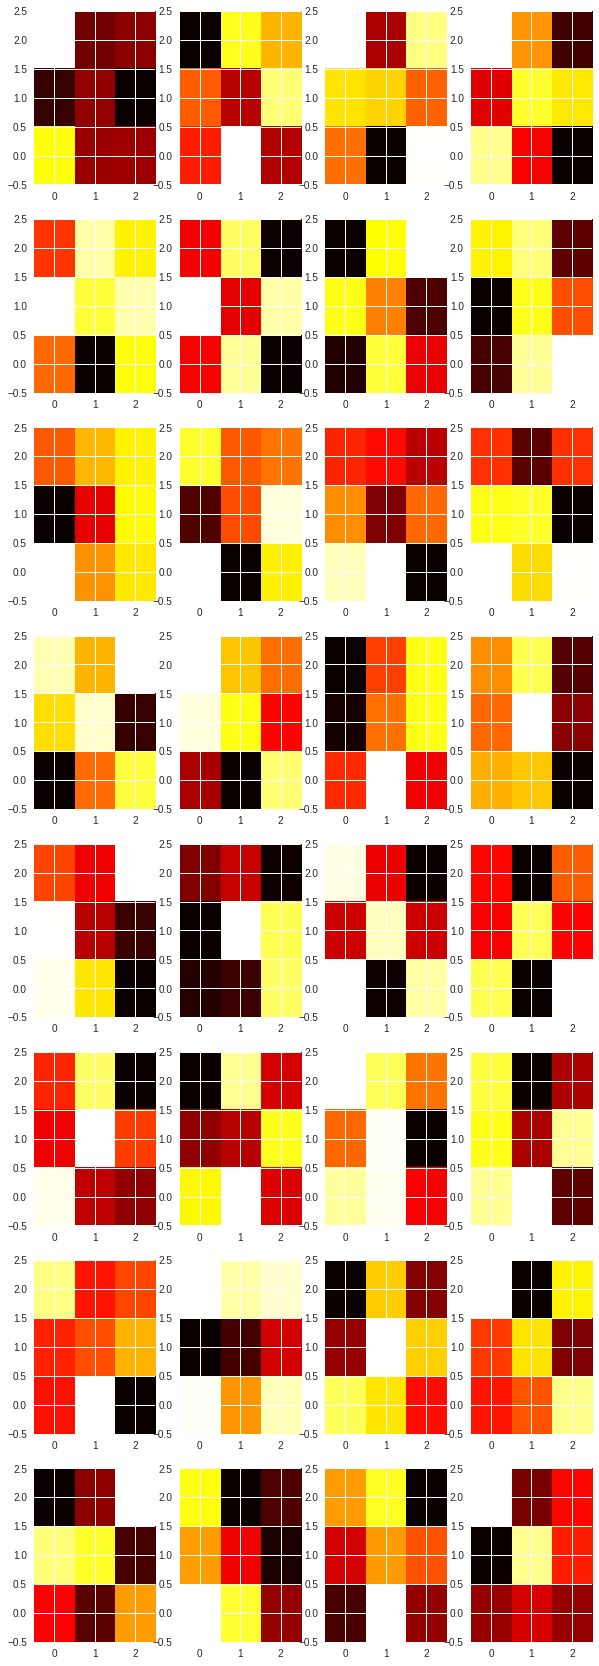

In [28]:
plt.figure(figsize=(10, 30))
for i in range(32):
    plt.subplot(8, 4, i + 1)
    plt.imshow(weights[0][:, :, i, 0], origin='lower', cmap='hot')
    plt.axis('auto')


## Eval Dev

In [ ]:
def get_validation_files(task):
    validation_path = "/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/"
    task_path = os.path.join(validation_path, task)
    npy_files = glob.glob(os.path.join(task_path, "*.npy"))
    validation_files = []
    for npy_file in npy_files:
        trackid = '_'.join(os.path.basename(npy_file).split('.')[0].split('_')[:2])
        txt_file = glob.glob(os.path.join(task_path, "{}*.txt".format(trackid)))
        if len(txt_file) > 0:
            txt_file = txt_file[0]
            validation_files.append([npy_file, txt_file])
        else:
            print('coudnt find text path')
    
    return validation_files


def time_freq_to_ragged_time_series(times, freqs):
    max_time = np.max(times)
    t_uniform = np.arange(0, max_time, 256./44100.)
    time_idx = np.digitize(times, t_uniform) - 1
    
    freq_list = [[] for _ in t_uniform]
    for i, f in zip(time_idx, freqs):
        if f > 0:
            freq_list[i].append(f)
    
    freq_arrays = [np.array(lst) for lst in freq_list]
    return t_uniform, freq_arrays


def time_freq_fill_zeros(times, freqs):
    max_time = np.max(times)
    t_uniform = np.arange(0, max_time, 256./44100.)
    time_idx = np.digitize(times, t_uniform) - 1
    freq_array = np.zeros(t_uniform.shape)
    for i, f in zip(time_idx, freqs):
        freq_array[i] = f

    return t_uniform, freq_array


def get_best_thresh_multif0(model):
    """Use validation set to get the best threshold value
    """
    # get validation files
    validation_files = get_validation_files('multif0')

    thresh_vals = np.arange(0.1, 1.0, 0.1)
    thresh_scores = {t: [] for t in thresh_vals}
    n_validation = len(validation_files)
    for i, (npy_file, target_file) in enumerate(validation_files):
        print("{} / {}".format(i + 1, n_validation))
        
        # generate prediction on numpy file
        predicted_outputs, input_hcqt = \
            get_single_test_prediction(model, npy_file=npy_file)
        predicted_output = predicted_outputs[0]
                
        # load ground truth labels
        temp_times, temp_freqs = mir_eval.io.load_time_series(target_file)
        ref_times, ref_freqs = time_freq_to_ragged_time_series(temp_times, temp_freqs)

        for thresh in thresh_vals:
            # get multif0 output from prediction
            est_times, est_freqs = \
                evaluate.pitch_activations_to_mf0(predicted_output, thresh)

            # get multif0 metrics and append
            scores = mir_eval.multipitch.evaluate(
                ref_times, ref_freqs, est_times, est_freqs)
            thresh_scores[thresh].append(scores['Accuracy'])

    avg_thresh = [np.mean(thresh_scores[t]) for t in thresh_vals]
    best_thresh = thresh_vals[np.argmax(avg_thresh)]
    print("Best Threshold is {}".format(best_thresh))
    print("Best validation accuracy is {}".format(np.max(avg_thresh)))
    print("Validation accuracy at 0.5 is {}".format(np.mean(thresh_scores[0.5])))

    return best_thresh

def get_best_thresh_singlef0(model, task):
    thresh_vals = np.arange(0, 1, 0.1)
    mel_accuracy = {v: [] for v in thresh_vals}

    validation_files = get_validation_files(task)

    n_validation = len(validation_files)
    for i, (npy_file, target_file) in enumerate(validation_files):
        print("{} / {}".format(i + 1, n_validation))
        # generate prediction on numpy file
        predicted_outputs, input_hcqt = \
            get_single_test_prediction(model, npy_file=npy_file)

        if task == 'melody':
            predicted_output = predicted_outputs[1]
        elif task == 'bass':
            predicted_output = predicted_outputs[2]
        elif task == 'vocal':
            predicted_output = predicted_outputs[3]
            
        temp_times, temp_freqs = mir_eval.io.load_time_series(target_file)
        ref_times, ref_freqs = time_freq_fill_zeros(temp_times, temp_freqs)

        for thresh in thresh_vals:
            est_times, est_freqs = evaluate.pitch_activations_to_singlef0(predicted_output, thresh)
            mel_scores = mir_eval.melody.evaluate(ref_times, ref_freqs, est_times, est_freqs)
            mel_accuracy[thresh].append(mel_scores['Overall Accuracy'])

    avg_thresh = [np.mean(mel_accuracy[t]) for t in thresh_vals]
    best_thresh = thresh_vals[np.argmax(avg_thresh)]
    print("Best Threshold is {}".format(best_thresh))
    print("Best validation accuracy is {}".format(np.max(avg_thresh)))
    print("Validation accuracy at 0.5 is {}".format(np.mean(mel_accuracy[0.5])))

    return best_thresh

In [30]:
best_thresh_mf0 = get_best_thresh_multif0(model)    

/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/multif0/FleetwoodMac_Rhiannon_multif0_nosynth_annotation.txt


/home/rmb456/anaconda2/lib/python2.7/site-packages/mir_eval/multipitch.py:410: UserWarning: Estimate times not equal to reference times. Resampling to common time base.
  warnings.warn("Estimate times not equal to reference times. "


/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/multif0/Live_IAlone_multif0_nosynth_annotation.txt
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/multif0/SweetLights_YouLetMeDown_multif0_nosynth_annotation.txt
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/multif0/HezekiahJones_BorrowedHeart_multif0_nosynth_annotation.txt
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/multif0/Plasma_GoodShout_multif0_nosynth_annotation.txt
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/multif0/TomPettyAndTheHeartbreakers_IWontBackDown_multif0_nosynth_annotation.txt
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/multif0/TrevorAndTheSoundwaves_AloneAndSad_multif0_nosynth_annotation.txt
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/multif0/LynyrdSkynyrd_FreeBird_multif0_nosynth_annotation.txt
/scratch/rmb456/multif0_ismir2017/multitask_test_data/v

In [31]:
best_thresh_mel = get_best_thresh_singlef0(model, 'melody')

/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/melody/BrandonWebster_DontHearAThing_MIX_input.npy
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/melody/KtTunstall_SuddenlyISee_MIX_input.npy
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/melody/BradPaisley_MudOnTheTires_MIX_input.npy
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/melody/SweetLights_YouLetMeDown_MIX_input.npy
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/melody/HezekiahJones_BorrowedHeart_MIX_input.npy
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/melody/BrandonWebster_YesSirICanFly_MIX_input.npy
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/melody/MusicDelta_LatinJazz_MIX_input.npy
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/melody/TalkingHeads_PsychoKiller_MIX_input.npy
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validatio

In [32]:
best_thresh_bass = get_best_thresh_singlef0(model, 'bass')

/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/bass/TaylorSwift_YouBelongWithMe_MIX_input.npy
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/bass/TaylorSwift_LoveStory_MIX_input.npy
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/bass/CarlDouglas_KungFuFighting_MIX_input.npy
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/bass/TheKillers_SomebodyToldMe_MIX_input.npy
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/bass/TheAllAmericanRejects_DirtyLittleSecret_MIX_input.npy
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/bass/KtTunstall_SuddenlyISee_MIX_input.npy
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/bass/BillyIdol_WhiteWedding_MIX_input.npy
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/bass/TrevorAndTheSoundwaves_AloneAndSad_MIX_input.npy
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validatio

In [33]:
best_thresh_vocal = get_best_thresh_singlef0(model, 'vocal')

/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/vocal/KtTunstall_SuddenlyISee_MIX_input.npy
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/vocal/TrevorAndTheSoundwaves_AloneAndSad_MIX_input.npy
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/vocal/BradPaisley_MudOnTheTires_MIX_input.npy
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/vocal/LynyrdSkynyrd_FreeBird_MIX_input.npy
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/vocal/BrandonWebster_YesSirICanFly_MIX_input.npy
/scratch/rmb456/multif0_ismir2017/multitask_test_data/validation_data/vocal/TalkingHeads_PsychoKiller_MIX_input.npy
Best Threshold is 0.5
Best validation accuracy is 0.622408351864
Validation accuracy at 0.5 is 0.622408351864


In [19]:
def get_test_files(test_set_name):
    test_parent = '/scratch/rmb456/multif0_ismir2017/multitask_test_data/'
    if test_set_name in ['bach10', 'maps', 'medleydb_multif0', 'su']:
        test_dir = os.path.join(test_parent, test_set_name)
        extension = 'txt'
    elif test_set_name in ['ikala', 'medleydb_melody', 'orchset']:
        test_dir = os.path.join(test_parent, test_set_name)
        extension = 'csv'
    elif test_set_name == 'weimar_jazz_bass':
        test_dir = os.path.join(test_parent, 'weimar_jazz', 'bass')
        extension = 'csv'
    elif test_set_name == 'weimar_jazz_melody':
        test_dir = os.path.join(test_parent, 'weimar_jazz', 'melody')
        extension = 'csv'
    
    npy_files = glob.glob(os.path.join(test_dir, "*.npy"))
    test_files = []
    for npy_file in npy_files:
        trackid = '_'.join(os.path.basename(npy_file).split('.')[0].split('_')[:2])
        txt_file = glob.glob(os.path.join(test_dir, "{}*.{}".format(trackid, extension)))
        if len(txt_file) > 0:
            txt_file = txt_file[0]
            test_files.append([npy_file, txt_file])
        else:
            print('coudnt find text path')
    
    return test_files        


def score_singlef0_on_test_set(model, test_set, thresh=0.5):
    test_files = get_test_files(test_set)
    print("Scoring on {}".format(test_set))
    
    
    if test_set == 'orchset':
        delimiter = '\t'
    else:
        delimiter = ','

    if test_set in ['ikala']:
        task_idx = 3
    elif test_set in ['medleydb_melody', 'orchset', 'weimar_jazz_melody']:
        task_idx = 1
    elif test_set in ['weimar_jazz_bass']:
        task_idx = 2
    else:
        raise ValueError('invalid test set')

    all_scores = []
    n_test_files = len(test_files)
    for i, (npy_file, target_file) in enumerate(test_files):
        print("{} / {}".format(i + 1, n_test_files))
        # generate prediction on numpy file
        predicted_outputs, input_hcqt = \
            get_single_test_prediction(model, npy_file=npy_file)
        predicted_output = predicted_outputs[task_idx]
        
        file_keys = os.path.basename(npy_file).split('.')[0]
        
        ref_times, ref_freqs = mir_eval.io.load_time_series(target_file, delimiter=delimiter)
        est_times, est_freqs = evaluate.pitch_activations_to_singlef0(predicted_output, thresh)
        mel_scores = mir_eval.melody.evaluate(ref_times, ref_freqs, est_times, est_freqs)
        
        mel_scores['track'] = '_'.join(file_keys)
        all_scores.append(mel_scores)

    df = pd.DataFrame(all_scores)
    print(df.describe())
    return df

def score_multif0_on_test_set(model, test_set, thresh=0.5):
    """score a model on all files in a named test set
    """

    # get files for this test set
    test_files = get_test_files(test_set)
    task_idx = 0

    all_scores = []
    n_test_files = len(test_files)
    for i, (npy_file, target_file) in enumerate(test_files):

        print("{} / {}".format(i + 1, n_test_files))
        file_keys = os.path.basename(npy_file).split('.')[0]
        
        # generate prediction on numpy file
        predicted_outputs, input_hcqt = \
            get_single_test_prediction(model, npy_file=npy_file)

        predicted_output = predicted_outputs[task_idx]
        # get multif0 output from prediction
        est_times, est_freqs = evaluate.pitch_activations_to_mf0(
            predicted_output, thresh
        )

        # load ground truth labels
        ref_times, ref_freqs = \
            mir_eval.io.load_ragged_time_series(target_file)

        # get multif0 metrics and append
        scores = mir_eval.multipitch.evaluate(
            ref_times, ref_freqs, est_times, est_freqs)
        scores['track'] = '_'.join(file_keys)
        all_scores.append(scores)

    df = pd.DataFrame(all_scores)
    print(df.describe())
    return df

In [42]:
df_bach10 = score_multif0_on_test_set(model, 'bach10', best_thresh_mf0)

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
       Precision     Recall   Accuracy  Substitution Error  Miss Error  \
count  10.000000  10.000000  10.000000           10.000000   10.000000   
mean    0.687728   0.848775   0.612618            0.069035    0.082190   
std     0.038600   0.023559   0.035513            0.016000    0.014039   
min     0.637239   0.823599   0.571206            0.038762    0.051728   
25%     0.662054   0.832371   0.591856            0.063629    0.079731   
50%     0.684650   0.845007   0.614970            0.069240    0.080246   
75%     0.709057   0.849729   0.624572            0.080212    0.090642   
max     0.766686   0.897567   0.694577            0.093433    0.103793   

       False Alarm Error  Total Error  Chroma Precision  Chroma Recall  \
count          10.000000    10.000000         10.000000      10.000000   
mean            0.319502     0.470727          0.712736       0.879728   
std             0.062859     0.062405   

In [22]:
df_maps = score_multif0_on_test_set(model, 'maps', 0.3) #best_thresh_mf0)

1 / 270


/home/rmb456/anaconda2/lib/python2.7/site-packages/mir_eval/multipitch.py:410: UserWarning: Estimate times not equal to reference times. Resampling to common time base.
  warnings.warn("Estimate times not equal to reference times. "


2 / 270
3 / 270
4 / 270
5 / 270
6 / 270
7 / 270
8 / 270
9 / 270
10 / 270
11 / 270


KeyboardInterrupt: 

In [25]:
df_mdb_mf0 = score_multif0_on_test_set(model, 'medleydb_multif0', 0.3) #best_thresh_mf0)

1 / 16


ValueError: A frequency of 0.0 was found which is less than the minimum allowable value of min_freq = 20.0 (did you supply frequency values in Hz?)

In [43]:
df_su = score_multif0_on_test_set(model, 'su', best_thresh_mf0)

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
       Precision     Recall   Accuracy  Substitution Error  Miss Error  \
count  10.000000  10.000000  10.000000           10.000000   10.000000   
mean    0.615128   0.615059   0.438361            0.167835    0.217107   
std     0.129286   0.098237   0.082193            0.050570    0.101825   
min     0.413123   0.459339   0.277961            0.093777    0.087054   
25%     0.564370   0.573702   0.396239            0.128327    0.143067   
50%     0.625971   0.632792   0.449823            0.165090    0.204880   
75%     0.681006   0.649399   0.465353            0.196898    0.267782   
max     0.830002   0.768341   0.576026            0.258195    0.435490   

       False Alarm Error  Total Error  Chroma Precision  Chroma Recall  \
count          10.000000    10.000000         10.000000      10.000000   
mean            0.259655     0.644597          0.674722       0.674898   
std             0.216624     0.206735   

In [46]:
df_mdb_mel = score_singlef0_on_test_set(model, 'medleydb_melody', best_thresh_mel)

Scoring on medleydb_melody
1 / 27
2 / 27
3 / 27
4 / 27
5 / 27
6 / 27
7 / 27
8 / 27
9 / 27
10 / 27
11 / 27
12 / 27
13 / 27
14 / 27
15 / 27
16 / 27
17 / 27
18 / 27
19 / 27
20 / 27
21 / 27
22 / 27
23 / 27
24 / 27
25 / 27
26 / 27
27 / 27
       Voicing Recall  Voicing False Alarm  Raw Pitch Accuracy  \
count       27.000000            27.000000           27.000000   
mean         0.526746             0.202956            0.635473   
std          0.203647             0.155822            0.155474   
min          0.168228             0.015671            0.301518   
25%          0.395938             0.068757            0.564184   
50%          0.473149             0.160413            0.643417   
75%          0.688275             0.287386            0.735881   
max          0.944622             0.554415            0.974081   

       Raw Chroma Accuracy  Overall Accuracy  
count            27.000000         27.000000  
mean              0.711655          0.575241  
std               0.127274    

In [51]:
df_orchset = score_singlef0_on_test_set(model, 'orchset', best_thresh_mel)

Scoring on orchset
1 / 64
2 / 64
3 / 64
4 / 64
5 / 64
6 / 64
7 / 64
8 / 64
9 / 64
10 / 64
11 / 64
12 / 64
13 / 64
14 / 64
15 / 64
16 / 64
17 / 64
18 / 64
19 / 64
20 / 64
21 / 64
22 / 64
23 / 64
24 / 64
25 / 64
26 / 64
27 / 64
28 / 64
29 / 64
30 / 64
31 / 64
32 / 64
33 / 64
34 / 64
35 / 64
36 / 64
37 / 64
38 / 64
39 / 64
40 / 64
41 / 64
42 / 64
43 / 64
44 / 64
45 / 64
46 / 64
47 / 64
48 / 64
49 / 64
50 / 64
51 / 64
52 / 64
53 / 64
54 / 64
55 / 64
56 / 64
57 / 64
58 / 64
59 / 64
60 / 64
61 / 64
62 / 64
63 / 64
64 / 64
       Voicing Recall  Voicing False Alarm  Raw Pitch Accuracy  \
count       64.000000            64.000000           64.000000   
mean         0.531599             0.375282            0.367032   
std          0.198762             0.232977            0.253803   
min          0.110283             0.018868            0.002339   
25%          0.378738             0.194937            0.142319   
50%          0.547934             0.331679            0.345577   
75%          0.6

In [54]:
df_wj_mel = score_singlef0_on_test_set(model, 'weimar_jazz_melody', best_thresh_mel)

Scoring on weimar_jazz_melody
1 / 454
2 / 454
3 / 454
4 / 454
5 / 454
6 / 454
7 / 454
8 / 454
9 / 454
10 / 454
11 / 454
12 / 454
13 / 454
14 / 454
15 / 454
16 / 454
17 / 454
18 / 454
19 / 454
20 / 454
21 / 454
22 / 454
23 / 454
24 / 454
25 / 454
26 / 454
27 / 454
28 / 454
29 / 454
30 / 454
31 / 454
32 / 454
33 / 454
34 / 454
35 / 454
36 / 454
37 / 454
38 / 454
39 / 454
40 / 454
41 / 454
42 / 454
43 / 454
44 / 454
45 / 454
46 / 454
47 / 454
48 / 454
49 / 454
50 / 454
51 / 454
52 / 454
53 / 454
54 / 454
55 / 454
56 / 454
57 / 454
58 / 454
59 / 454
60 / 454
61 / 454
62 / 454
63 / 454
64 / 454
65 / 454
66 / 454
67 / 454
68 / 454
69 / 454
70 / 454
71 / 454
72 / 454
73 / 454
74 / 454
75 / 454
76 / 454
77 / 454
78 / 454
79 / 454
80 / 454
81 / 454
82 / 454
83 / 454
84 / 454
85 / 454
86 / 454
87 / 454
88 / 454
89 / 454
90 / 454
91 / 454
92 / 454
93 / 454
94 / 454
95 / 454
96 / 454
97 / 454
98 / 454
99 / 454
100 / 454
101 / 454
102 / 454
103 / 454
104 / 454
105 / 454
106 / 454
107 / 454
108 / 45

In [52]:
df_wj_bass = score_singlef0_on_test_set(model, 'weimar_jazz_bass', best_thresh_bass)

Scoring on weimar_jazz_bass
1 / 40
2 / 40
3 / 40
4 / 40
5 / 40
6 / 40
7 / 40
8 / 40
9 / 40
10 / 40
11 / 40
12 / 40
13 / 40
14 / 40
15 / 40
16 / 40
17 / 40
18 / 40
19 / 40
20 / 40
21 / 40
22 / 40
23 / 40
24 / 40
25 / 40
26 / 40
27 / 40
28 / 40
29 / 40
30 / 40
31 / 40
32 / 40
33 / 40
34 / 40
35 / 40
36 / 40
37 / 40
38 / 40
39 / 40
40 / 40
       Voicing Recall  Voicing False Alarm  Raw Pitch Accuracy  \
count       40.000000            40.000000           40.000000   
mean         0.273573             0.118534            0.542557   
std          0.140502             0.077797            0.159745   
min          0.041236             0.000000            0.124962   
25%          0.163867             0.072127            0.464384   
50%          0.272457             0.096452            0.551131   
75%          0.345574             0.165879            0.635654   
max          0.630889             0.313307            0.887676   

       Raw Chroma Accuracy  Overall Accuracy  
count            40

In [53]:
df_ikala = score_singlef0_on_test_set(model, 'ikala', best_thresh_vocal)

Scoring on ikala
1 / 252
2 / 252
3 / 252
4 / 252
5 / 252
6 / 252
7 / 252
8 / 252
9 / 252
10 / 252
11 / 252
12 / 252
13 / 252
14 / 252
15 / 252
16 / 252
17 / 252
18 / 252
19 / 252
20 / 252
21 / 252
22 / 252
23 / 252
24 / 252
25 / 252
26 / 252
27 / 252
28 / 252
29 / 252
30 / 252
31 / 252
32 / 252
33 / 252
34 / 252
35 / 252
36 / 252
37 / 252
38 / 252
39 / 252
40 / 252
41 / 252
42 / 252
43 / 252
44 / 252
45 / 252
46 / 252
47 / 252
48 / 252
49 / 252
50 / 252
51 / 252
52 / 252
53 / 252
54 / 252
55 / 252
56 / 252
57 / 252
58 / 252
59 / 252
60 / 252
61 / 252
62 / 252
63 / 252
64 / 252
65 / 252
66 / 252
67 / 252
68 / 252
69 / 252
70 / 252
71 / 252
72 / 252
73 / 252
74 / 252
75 / 252
76 / 252
77 / 252
78 / 252
79 / 252
80 / 252
81 / 252
82 / 252
83 / 252
84 / 252
85 / 252
86 / 252
87 / 252
88 / 252
89 / 252
90 / 252
91 / 252
92 / 252
93 / 252
94 / 252
95 / 252
96 / 252
97 / 252
98 / 252
99 / 252
100 / 252
101 / 252
102 / 252
103 / 252
104 / 252
105 / 252
106 / 252
107 / 252
108 / 252
109 / 252
1

In [19]:
x_freqs = np.repeat(np.arange(3)[np.newaxis, :], 10, axis=0).T[np.newaxis, :, :, np.newaxis]
x_patch = np.zeros((1, 3, 10, 5))
np.concatenate([x_freqs, x_patch], axis=3).shape

(1, 3, 10, 6)